# OpenML Impact Analysis

In [1]:
!pip install pandas --quiet
!pip install matplotlib --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## Data cleaning and preprocessing

In [3]:
path1 = '../data/collected_papers.csv' # Original list of collected papers
path2 = "../data/Final_survey_data.csv" # Survey Results

df = pd.read_csv(path2)

print("Total no of reviews recieved: ", len(df))
df.head()

Total no of reviews recieved:  1715


,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,"If unclear, one sentence explanation?",...,Does the paper upload datasets to OpenML?,"If yes, which dataset?",Does the paper upload experiment data to OpenML?,"if yes: short (e.g., 1 sentence) explanation: what type of experiments?",Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?"
0,2025-01-20 17:42:12,1236,Optimal or Greedy Decision Trees? Revisiting t...,2024.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,No,NaN,No,NaN,NaN,NaN
1,2025-01-21 10:38:07,675,Impact of sampling on learning asymmetric-entr...,2019.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,No,NaN,No,NaN,NaN,NaN
2,2025-01-21 13:41:44,1377,Efficient density and cluster based incrementa...,2022.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,No,NaN,No,NaN,NaN,NaN
3,2025-01-21 13:44:29,1597,Consensus driven on-device hyperparameter opti...,2024.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,No,NaN,No,NaN,NaN,NaN
4,2025-01-21 13:49:29,273,Model selection with bootstrap validation,2023.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,No,NaN,No,NaN,NaN,NaN


In [4]:
pd.DataFrame(df.columns)

,0
0,Timestamp
1,Paper ID (from shared sheet)
2,Paper Title
3,Paper Year
4,Paper Available
5,Paper in English
6,Does the paper have at least 1 current OpenML ...
7,"If yes, which Core Members?"
8,Does the paper use datasets from OpenML?
9,"If unclear, one sentence explanation?"


### Sanity Check:
1. Remove duplicates
2. Match paper ID and paper title from original list
3. Remove papers with wrong year (<2014)
4. Remove empty rows
5. Remove papers with year == 2025

In [5]:
Total_papers = pd.read_csv(path1) # Original list of scraped paper
print("Total scraped papers: ", len(Total_papers))

Total scraped papers:  1786


In [6]:
assigned_papers_dict = Total_papers[["Paper ID", "Title"]].set_index('Paper ID').to_dict()
assigned_papers_dict = assigned_papers_dict["Title"]
assigned_papers_dict

{177: 'Plaster: An Integration, Benchmark and Development Framework for Heterogeneous Metadata Normalization Methods',
 1404: 'On the predictive power of meta-features in OpenML',
 46: 'Probabilistic matrix factorization for automated machine learning',
 155: 'Challenges and opportunities of generative models on tabular data',
 1593: 'Interpretable machine learning for time-to-event prediction in medicine and healthcare',
 1234: 'Application of machine learning for fleet-based condition monitoring of ball screw drives in machine tools',
 1535: 'How data scientistswork together with domain experts in scientific collaborations: To find the right answer or to ask the right question?',
 1709: 'Open graph benchmark: Datasets for machine learning on graphs',
 573: 'On efficiently explaining graph-based classifiers',
 324: 'OpenML: a networked science platform for machine learning',
 1344: 'LBC: Language-Based-Classifier for Out-Of-Variable Generalization',
 290: 'Distributed hybrid quantum-c

In [7]:
sheet1 = Total_papers[["Paper ID", "openml-suites-2021", "openml-python-2021", "openml-2014", "openml-r-2017"]]
sheet1.rename(columns={"Paper ID": "Paper ID (from shared sheet)"}, inplace=True)
df = df.merge(sheet1, on="Paper ID (from shared sheet)", how="left")
df.head()

/tmp/ipykernel_353930/2586035974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sheet1.rename(columns={"Paper ID": "Paper ID (from shared sheet)"}, inplace=True)


,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,"If unclear, one sentence explanation?",...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017
0,2025-01-20 17:42:12,1236,Optimal or Greedy Decision Trees? Revisiting t...,2024.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,NaN,False,True,True,False
1,2025-01-21 10:38:07,675,Impact of sampling on learning asymmetric-entr...,2019.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,NaN,False,False,True,False
2,2025-01-21 13:41:44,1377,Efficient density and cluster based incrementa...,2022.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,NaN,False,False,True,False
3,2025-01-21 13:44:29,1597,Consensus driven on-device hyperparameter opti...,2024.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,NaN,False,False,True,False
4,2025-01-21 13:49:29,273,Model selection with bootstrap validation,2023.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,NaN,False,False,True,True


In [8]:
# Step 1: Remove Dublicates

# Duplicate entries
duplicate_rows = df[df.duplicated(subset=["Paper ID (from shared sheet)"], keep=False)]

print(len(duplicate_rows))
duplicate_rows

26


,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,"If unclear, one sentence explanation?",...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017
1,2025-01-21 10:38:07,675,Impact of sampling on learning asymmetric-entr...,2019.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,NaN,False,False,True,False
73,2025-01-24 6:24:55,895,OBOE: Collaborative filtering for AutoML model...,2019.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,Experiments were conducted using midsize OpenM...,NaN,False,False,True,False
74,2025-01-24 7:48:18,1279,Similarity Measures Recommendation for Mixed D...,2024.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,The main focus of the paper is on the meta-lea...,NaN,False,False,True,False
75,2025-01-24 8:20:38,164,Disease classification using neighbourhood cen...,2023.0,Yes,Yes,No,NaN,No,NaN,...,No,NaN,No,NaN,The authors collected 60 classification datase...,NaN,False,False,True,False
83,2025-01-24 15:39:39,31,Decision Tree Induction Through Meta-learning,2022.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,No,False,False,True,False
84,2025-01-24 15:42:55,364,Multiple adaptive Bayesian linear regression f...,2017.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,No,False,False,True,False
455,2025-02-08 12:16:52,1119,On evaluation of automl systems,2020.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,No,False,False,True,False
456,2025-02-08 13:07:11,1119,On evaluation of automl systems,2020.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,No,False,False,True,False
489,2025-02-08 17:41:59,901,MementoML: Performance of selected machine lea...,2020.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,No,False,False,True,False
491,2025-02-08 17:43:13,329,Beyond TreeSHAP: Efficient Computation of Any-...,2024.0,Yes,Yes,No,NaN,No,NaN,...,No,NaN,No,NaN,does not cite OpenML,No,False,True,False,False


In [9]:
duplicates = df[df.duplicated(subset=["Paper ID (from shared sheet)"], keep=False)]
# Save duplicates to a separate DataFrame before removal
duplicates_removed = df[df.duplicated(subset=["Paper ID (from shared sheet)"], keep="first")]

df = df.drop_duplicates(subset=["Paper ID (from shared sheet)"], keep="first")

print(len(duplicates_removed))
duplicates_removed
# ToDo - better strategy to remove duplicates - ask reviewers to correct them.

13


,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,"If unclear, one sentence explanation?",...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017
456,2025-02-08 13:07:11,1119,On evaluation of automl systems,2020.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,No,False,False,True,False
524,2025-02-09 14:48:36,329,Beyond TreeSHAP: Efficient Computation of Any-...,2024.0,Yes,Yes,No,NaN,Yes,openml is only cited in the arxiv version (sup...,...,No,NaN,No,NaN,NaN,No,False,True,False,False
644,2025-02-17 10:07:21,1467,Towards automated imbalanced learning with dee...,2022.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,No,False,False,True,False
785,NaN,675,Impact of sampling on learning asymmetric-entr...,2019.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,No,False,False,True,False
896,NaN,31,Decision Tree Induction Through Meta-learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Submitted through form,NaN,False,False,True,False
897,NaN,364,Multiple adaptive Bayesian linear regression f...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Submitted through form,NaN,False,False,True,False
946,NaN,881,Clustering Under Radius Constraints Using Mini...,2024.0,NaN,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,NaN,No,False,False,True,False
1263,NaN,1472,Diffimpute: Tabular data imputation with denoi...,2024.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,conference paper,NaN,False,False,True,False
1290,NaN,78,A Genetic Programming Encoder for Increasing A...,2023.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,conference paper,NaN,False,False,True,False
1595,NaN,895,OBOE: Collaborative filtering for AutoML model...,2019.0,Yes,Yes,No,NaN,Yes,NaN,...,No,NaN,No,NaN,OpenML datasets are used as a key resource for...,NaN,False,False,True,False


In [10]:
print("No of reviews after dublicate removal: ", len(df))

No of reviews after dublicate removal:  1702


In [11]:
# Step 2: Remove mismatches

mismatches = []

for index, row in df.iterrows():
    try:
        paper_id = row["Paper ID (from shared sheet)"]
        paper_title = row["Paper Title"].strip().lower()
        assigned_title = assigned_papers_dict.get(paper_id).strip().lower()

        if paper_title not in assigned_title:
            mismatches.append({
                "Paper ID": paper_id,
                "Given Title": row["Paper Title"],
                "Expected Title": assigned_papers_dict.get(paper_id, "Not Found")
            })

    except Exception as e:
        mismatches.append({
            "Paper ID": row["Paper ID (from shared sheet)"],
            "Error": str(e),
            "Given Title": row.get("Paper Title", "Not Found")
        })
        continue

mismatches_df = pd.DataFrame(mismatches)
mismatches_df



,Paper ID,Given Title,Expected Title
0,1030,Convolutional neural networks for classificati...,Convolutional neural networks for classificati...
1,1246,Adapting TabPFN for Zero-Inflated Metagenomics...,Adapting TabPFN for Zero-Inflated Metagenomic ...
2,1458,AutoEn: An AutoML method based on ensembles of...,AutoEn: an AutoML method based on ensembles of...
3,26,Don’t Blindly Use Data: Towards a Data Stateme...,Don't Blindly Use Data: Towards a Data Stateme...
4,966,OpenML-Connect: A C++ connection library for O...,OpenML-Connect: A C++\nconnection library for ...
5,1397,MLPro — An integrative middleware framework fo...,MLPro-A synoptic framework for standardized ma...
6,901,MementoML: Performance of selected machine lea...,Selection-based per-instance heuristic generat...
7,123,D7.7 AutoAI Benchmarks v.3 Report,D7. 7 AutoAI Benchmarks v. 3 Report
8,267,out of distribution learning,OUT-OF-DISTRIBUTION LEARNING
9,240,A Meta-Level Learning Algorithm for Sequential...,PROMISSING: Pruning Missing Values in Neural N...


In [12]:
# Mismatched paper ID and title - 901, 240, 881, 1467, 1472, 108 - to be removed
paper_ids_to_remove = [901, 240, 881, 1467, 1472, 108] #contact authors

df = df[~df["Paper ID (from shared sheet)"].isin(paper_ids_to_remove)]
df[df["Paper ID (from shared sheet)"] == 108]

,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,"If unclear, one sentence explanation?",...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017


In [13]:
print("No of reviews after duplicate removal: ", len(df))

No of reviews after duplicate removal:  1696


In [14]:
# Drop rows with all NaN or NaT values
df = df.dropna(how="all")

len(df)

1696

In [15]:
# Remove papers with a year before 2014 - temporary messure. some incorrect paper year.

# df["Paper Year"] = df["Paper Year"].astype(int)

# # Check the updated column type
# print(df["Paper Year"].dtypes)

df = df[df["Paper Year"] >= 2014]
len(df)

1665

In [43]:
df[(df["Paper Year"] > 2025) | (df["Paper Year"] < 2014)]


,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,"If unclear, one sentence explanation?",...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017
595,2025-02-09 17:34:05,959,Taranjeet Singh2 Akash Jain3 Shiv Baran Singh4...,9999.0,"invalid resource, no title given, link is death",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False


In [16]:
print("Paper with wrong year: ", 1696-1665)

Paper with wrong year:  31


In [17]:
count_yes = df["Paper Available"].value_counts().get("Yes", 0)
print(count_yes)
print(len(df)-count_yes + (len(Total_papers)-1702))

1527
222


In [18]:
count_yes = df["Paper in English"].value_counts().get("Yes", 0)
print(count_yes)
print(len(df)-count_yes)


1599
66


In [19]:
# No fo paper which are both not fully available and not in english
overlap = df[(df["Paper Available"] != "Yes") & (df["Paper in English"] != "Yes")]
len(overlap)

21

In [20]:

columns_to_analyze = ["openml-suites-2021", "openml-python-2021", "openml-2014", "openml-r-2017"]

# Calculate the percentage of True values for each column
percentages = Total_papers[columns_to_analyze].mean() * 100

# Print the results
for column, percentage in percentages.items():
    print(f"Percentage of papers with True for {column}: {percentage:.2f}%")


Percentage of papers with True for openml-suites-2021: 8.17%
Percentage of papers with True for openml-python-2021: 5.88%
Percentage of papers with True for openml-2014: 90.03%
Percentage of papers with True for openml-r-2017: 4.09%


In [21]:
# Filter rows not in final_df
not_in_final_df = df[~((df["Paper Available"] == "Yes") &  (df["Paper in English"] == "Yes"))]

print(len(not_in_final_df))
# Display the rows not in final_df
not_in_final_df[["Paper Available", "Paper in English"]]


183


,Paper Available,Paper in English
29,Thesis without online PDF,NaN
33,Yes,No
38,Paywall,NaN
94,Yes,No
102,No. Cannot find it anywhere for free.,NaN
...,...,...
1662,Yes,No
1670,Yes,No
1696,Yes,No
1711,No (dead link),NaN


In [22]:
# Should only consider paper available + in english
available_papers = df[(df["Paper Available"] == "Yes") & (df["Paper in English"] == "Yes")].copy()
print("Final number of papers for analysis: ", len(available_papers))

Final number of papers for analysis:  1482


Final statistics

1. Total exctracted paper: 1719
2. Paper used in analysis: 1482

## Analysis

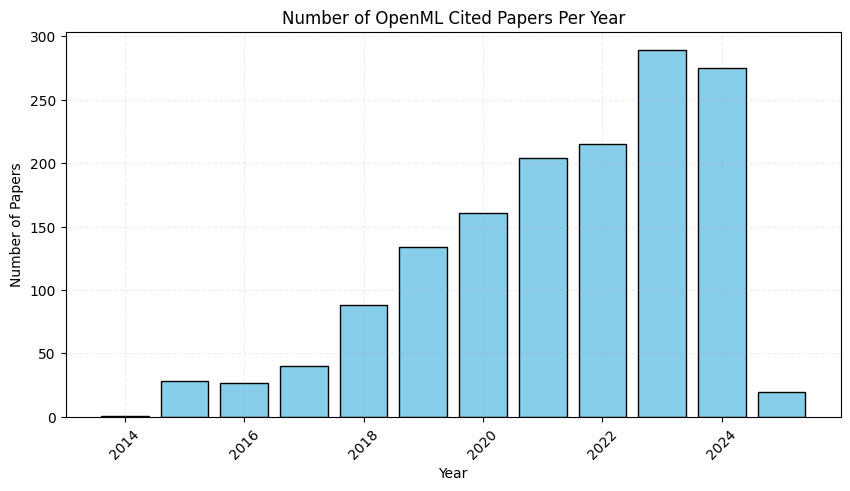

In [23]:

# Count the number of papers per year
papers_per_year = available_papers["Paper Year"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(papers_per_year.index, papers_per_year.values, color="skyblue", edgecolor="black")

plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("Number of OpenML Cited Papers Per Year")
plt.xticks(rotation=45)
plt.grid(linestyle='--', alpha=0.2)

plt.show()


In [24]:
# What percentage of the papers does just cite OpenML, but not actively interact with it?

interaction_columns = [
    "Does the paper use datasets from OpenML?",
    "Does the paper use a collection (at least 2 or more) of datasets that are defined by OpenML designated to do benchmarking (e.g., openml benchmarking suites)?",
    "Does the paper use OpenML experiment data (i.e., utilise results from runs)? ",
    "Does the paper upload datasets to OpenML?",
    "Does the paper upload experiment data to OpenML?",
    "Does the paper interact in any other way with OpenML?"
]

just_citing_papers = available_papers[(available_papers[interaction_columns] == "No").all(axis=1)]

percentage_citing_only = (len(just_citing_papers) / len(available_papers)) * 100
print(len(just_citing_papers), round(percentage_citing_only, 2))

core_citing_papers = just_citing_papers[just_citing_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "Yes"]
print(len(core_citing_papers), round((len(core_citing_papers)/len(just_citing_papers))*100,2))


314 21.19
22 7.01


In [25]:
# out of above papers which just cites openml, % of paper citing Openml-2014 paper

just_citing_openml_2014 = just_citing_papers[just_citing_papers["openml-2014"] == True]
print(len(just_citing_openml_2014), (len(just_citing_openml_2014) / len(just_citing_papers)) * 100)


290 92.35668789808918


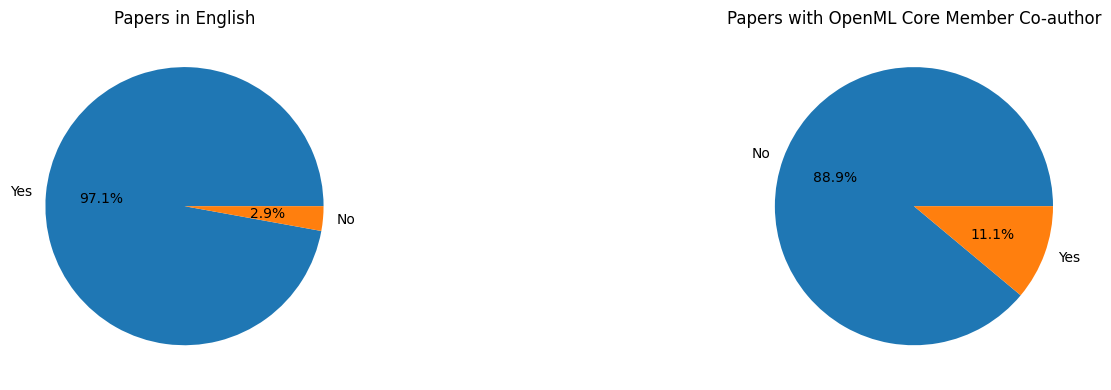

In [26]:
english_counts = df["Paper in English"].value_counts()

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.pie(english_counts, labels=english_counts.index, autopct="%1.1f%%")
plt.title("Papers in English")


core_member_counts = available_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"].value_counts()

plt.subplot(1, 2, 2)
plt.pie(core_member_counts, labels=core_member_counts.index, autopct="%1.1f%%")
plt.title("Papers with OpenML Core Member Co-author")

plt.tight_layout()
plt.show()

In [27]:
# Datasets

dataset_papers = available_papers[available_papers["Does the paper use datasets from OpenML?"] == "Yes"]
dataset_percentage = (len(dataset_papers) / len(available_papers)) * 100
print(dataset_percentage, (len(dataset_papers)))
print("Number of paper by core-authors: ",len(dataset_papers[dataset_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "Yes"]))

unclear_dataset_papers = available_papers.dropna(subset=["If unclear, one sentence explanation?"])
unclear_dataset_papers = unclear_dataset_papers[["Does the paper use datasets from OpenML?", "If unclear, one sentence explanation?"]]
unclear_dataset_papers

73.3468286099865 1087
Number of paper by core-authors:  121


,Does the paper use datasets from OpenML?,"If unclear, one sentence explanation?"
388,Unclear,"Datasets are used, OpenML reference in the ref..."
506,Unclear,supplementary material (should be removed)
510,Yes,one dataset from openml (diabetes)
523,Yes,"While the answer is probably yes, note that th..."
594,Unclear,"Does not explicitly state, but I think the ans..."
...,...,...
1706,Yes,"SWD, LEV, ERA, FacultySalaries, BNG pbc, BNG l..."
1707,Yes,"sonar, kc1-binary, tecator, har, gina_agnostic..."
1710,Yes,"heart, australian, mammographic, tic-tac-toe, ..."
1713,Yes,CC18


In [28]:
# Benchmark
benchmark_papers = available_papers[available_papers["Does the paper use a collection (at least 2 or more) of datasets that are defined by OpenML designated to do benchmarking (e.g., openml benchmarking suites)?"] == "Yes"]
benchmark_percentage = (len(benchmark_papers) / len(available_papers[available_papers["Paper Year"] >= 2017])) * 100
print(benchmark_percentage, len(benchmark_papers))

benchmark_datasets = benchmark_papers["If yes, which benchmark suites?"]

print("Number of paper by core-authors: ",len(benchmark_papers[benchmark_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "Yes"]))
# Print list of benchmark datasets
unique_benchmark_datasets = (
    benchmark_datasets.str.lower().str.strip().unique()
)


unique_benchmark_datasets

13.534361851332399 193
Number of paper by core-authors:  54


array(['meta-learning study (details can be found on https://www.openml.org/s/7)',
       'automl benchmark version 1', 'openml-cc18',
       'not mentioned. "all datasets are classification problem from openml benchmark."',
       'openml cc-18 benchmarking suite ((excluding datasets 554, 40923, 40927, 40996 due to technical issues)',
       'openml100', 'openml100, openml-cc18 and automl benchmark',
       'openml cc-18', 'automl benchmark 2019 (gijsbers)',
       'automl benchmark 2019, gijsbers', 'openml-cc18; openml-automl',
       'openml100, openml-cc18', 'automl benchmark',
       'openml-ctr23, automl', 'openml cc18', 'the openml-cc18',
       'openml-cc18 benchmark', 'amlb', 'ctr23,cc18',
       'hyper-parameter tuning of support vector machines',
       'study 14, openml100', 'unclear', 'openml-cc18, amlb',
       'openml-cc18, openml100', 'cc18', 'ctr23', 'openml100, cc18',
       'id: 297, 300 (titles ambiguous)',
       'openml-cc18, automl benchmark more classification',

In [29]:
#  Experiment data (Runs)

experiment_papers = available_papers[available_papers["Does the paper use OpenML experiment data (i.e., utilise results from runs)? "] == "Yes"]
experiment_percentage = (len(experiment_papers) / len(available_papers)) * 100

print(len(experiment_papers) ,experiment_percentage)
print("Number of paper by core-authors: ",len(experiment_papers[experiment_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "Yes"]))


experiment_papers[["Paper ID (from shared sheet)", "if yes: short (e.g., 1 sentence) explanation: how does it use this data?"]]


65 4.385964912280701
Number of paper by core-authors:  19


,Paper ID (from shared sheet),"if yes: short (e.g., 1 sentence) explanation: how does it use this data?"
4,273,For benchmarking a model selection method
6,245,model evaluations are used for meta-learning
11,911,uses evaluation for a benchmark
16,910,Algorithms / Flows
84,364,Meta-learning for BO
...,...,...
1548,1469,is uses model predictions from previous runs t...
1561,1516,na
1588,1552,"pulls experiment data for meta analysis, but n..."
1619,1667,Uses results from OpenML runs for comparison


In [30]:
upload_datasets = available_papers[available_papers["Does the paper upload datasets to OpenML?"] == "Yes"]

upload_datasets_percentage = len(upload_datasets) / len(available_papers) * 100

print( len(upload_datasets), upload_datasets_percentage)
print("Number of paper by core-authors: ",len(upload_datasets[upload_datasets["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "Yes"]))


upload_datasets[["Paper ID (from shared sheet)", "Does the paper upload datasets to OpenML?", "If yes, which dataset?"]]

23 1.5519568151147098
Number of paper by core-authors:  16


,Paper ID (from shared sheet),Does the paper upload datasets to OpenML?,"If yes, which dataset?"
108,506,Yes,"Unclear which dataset, but ""The datasets [...]..."
163,262,Yes,Meta-datasets based on a Bayesian Network Gene...
187,745,Yes,NaN
196,1229,Yes,NaN
236,1421,Yes,NaN
246,1468,Yes,75 datasets uploaded
275,672,Yes,QSAR datasets
367,538,Yes,21 datasets collected from studies in the lite...
426,207,Yes,NaN
429,1566,Yes,anomaly detection datasets created from synthe...


In [31]:
upload_experiment_data_papers = available_papers[available_papers["Does the paper upload experiment data to OpenML?"] == "Yes"]

upload_experiment_data_percentage = len(upload_experiment_data_papers) / len(available_papers) * 100

print(len(upload_experiment_data_papers),upload_experiment_data_percentage)
print("Number of paper by core-authors: ",len(upload_experiment_data_papers[upload_experiment_data_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "Yes"]))

upload_experiment_data_papers[["Paper ID (from shared sheet)", "if yes: short (e.g., 1 sentence) explanation: what type of experiments?"]]

27 1.8218623481781375
Number of paper by core-authors:  20


,Paper ID (from shared sheet),"if yes: short (e.g., 1 sentence) explanation: what type of experiments?"
21,507,Accuracy of bagging stable classifiers in the ...
85,1484,A large-scale benchmarking study based on 38 d...
108,506,Algorithm selection for classifiers
143,1301,324 runs on classification tasks ( datasets x ...
158,1111,"Sample a task, a ML algorithm and hyperparamer..."
163,262,More than 1000 experiments on data streams.
187,745,NaN
236,1421,NaN
275,672,results from multi-task learning on qsar data...
329,1201,AMLB benchmark


In [32]:
# paper year not mentioned.
available_papers[available_papers["Paper Year"].isna()]

,Timestamp,Paper ID (from shared sheet),Paper Title,Paper Year,Paper Available,Paper in English,Does the paper have at least 1 current OpenML Core Member as co-author?,"If yes, which Core Members?",Does the paper use datasets from OpenML?,"If unclear, one sentence explanation?",...,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?",Star it as some cool project to be showcased in our paper?,"If yes, please motivate your answer",Optional short description,"Is the paper a thesis (Bachelor's, Master's, or PhD)?",openml-suites-2021,openml-python-2021,openml-2014,openml-r-2017


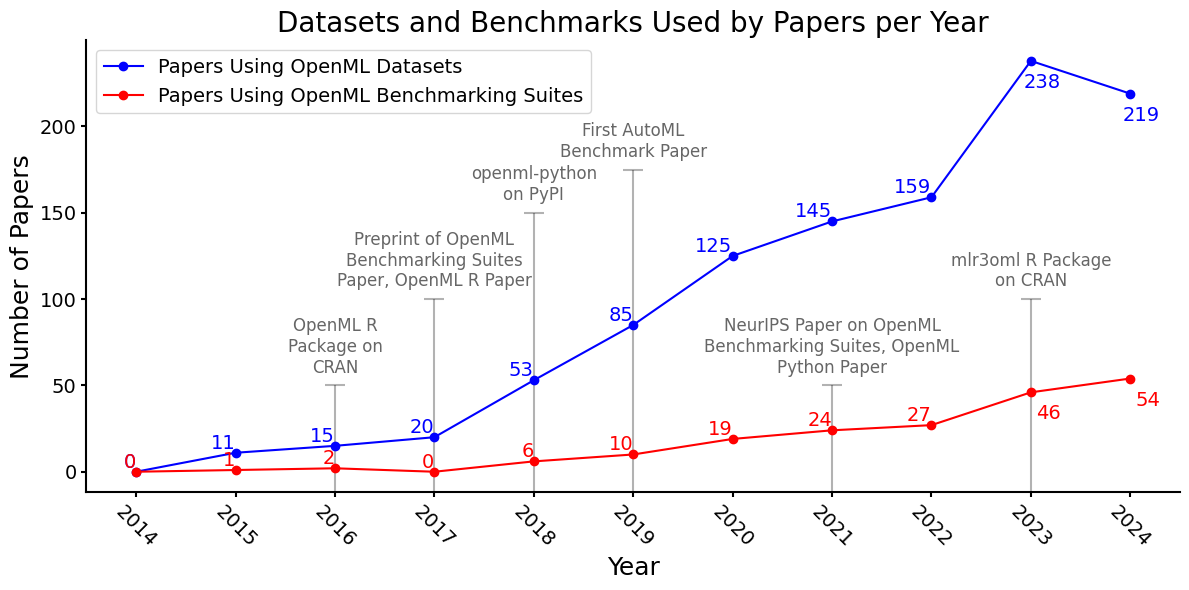

In [33]:
available_papers["Paper Year"] = available_papers["Paper Year"].astype(int)

available_papers["Datasets Used"] = available_papers["Does the paper use datasets from OpenML?"] == "Yes"
available_papers["Benchmark Used"] = available_papers["Does the paper use a collection (at least 2 or more) of datasets that are defined by OpenML designated to do benchmarking (e.g., openml benchmarking suites)?"] == "Yes"

# Group data by year for visualization
datasets_by_year = available_papers.groupby("Paper Year")["Datasets Used"].sum()
benchmarks_by_year = available_papers.groupby("Paper Year")["Benchmark Used"].sum()

# Filter out the year 2025
datasets_by_year_filtered = datasets_by_year[datasets_by_year.index != 2025]
benchmarks_by_year_filtered = benchmarks_by_year[benchmarks_by_year.index != 2025]

# Font sizes
LABEL_SIZE, TITLE_SIZE, NUMBER_SIZE = 14, 20, 14

def add_data_labels(ax, years, values, color):
    """Helper function to add data labels with consistent formatting"""
    for year, value in zip(years, values):
        if year >= 2023:
            va_alignment = 'top'
            y_offset, x_offset = -7, 0.3
        else:
            va_alignment = 'bottom'
            y_offset, x_offset = 0, 0

        ax.text(year + x_offset, value + y_offset, str(value),
                color=color, fontsize=NUMBER_SIZE,
                ha="right", va=va_alignment)

# Create figure and set padding
fig, ax = plt.subplots(figsize=(12, 6))
y_max = max(datasets_by_year_filtered.max(), benchmarks_by_year_filtered.max())
padding_factor = 1.05
ax.set_ylim(-(y_max * padding_factor - y_max), y_max * padding_factor)

# Define and add annotations
annotations = {
    2016: {"text": "OpenML R\nPackage on\nCRAN", "y_pos": 50},
    2017: {"text": "Preprint of OpenML\nBenchmarking Suites\nPaper, OpenML R Paper", "y_pos": 100},
    2018: {"text": "openml-python\non PyPI", "y_pos": 150},
    2019: {"text": "First AutoML\nBenchmark Paper", "y_pos": 175},
    2021: {"text": "NeurIPS Paper on OpenML\nBenchmarking Suites, OpenML\nPython Paper", "y_pos": 50},
    2023: {"text": "mlr3oml R Package\non CRAN", "y_pos": 100}
}

for year, anno_dict in annotations.items():
    y_pos = anno_dict["y_pos"]
    ax.vlines(x=year, ymin=ax.get_ylim()[0], ymax=y_pos, colors='black', alpha=.3)
    ax.hlines(y=y_pos, xmin=year-0.1, xmax=year+0.1, colors='black', alpha=.3)
    ax.text(year, y_pos + 5, anno_dict["text"],
            ha='center', va='bottom', fontsize=12,
            color='black', alpha=.6)

# Plot lines and add data labels
for data, color, label in [
    (datasets_by_year_filtered, 'blue', "Papers Using OpenML Datasets"),
    (benchmarks_by_year_filtered, 'red', "Papers Using OpenML Benchmarking Suites")
]:
    ax.plot(data.index, data.values, color=color, marker="o", label=label)
    add_data_labels(ax, data.index, data.values, color)

# Style the axes
ax.set_xticks(range(min(datasets_by_year.index), max(datasets_by_year.index)))
ax.set_xticklabels(range(min(datasets_by_year.index), max(datasets_by_year.index)),
                   rotation=-45)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, width=1.5)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and grid
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Number of Papers", fontsize=18)
ax.set_title("Datasets and Benchmarks Used by Papers per Year", fontsize=TITLE_SIZE)
ax.legend(fontsize=14)
#ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Save figure
with PdfPages("Datasets_and_Benchmark_per_year.pdf") as fh:
    fh.savefig(fig, bbox_inches="tight")

In [34]:
other_interactions = available_papers[available_papers["Does the paper interact in any other way with OpenML?"] == "Yes"]

other_interactions_percentage = len(other_interactions) / len(available_papers) * 100

print(len(other_interactions) , other_interactions_percentage)
print("Number of paper by core-authors: ",len(other_interactions[other_interactions["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "Yes"]))


other_interactions[["Does the paper interact in any other way with OpenML?", "if yes: short (e.g., 1 sentence) explanation how?"]]

85 5.7354925775978405
Number of paper by core-authors:  24


,Does the paper interact in any other way with OpenML?,"if yes: short (e.g., 1 sentence) explanation how?"
5,Yes,UI for OpenML
16,Yes,Weird/interesting use case for RL
23,Yes,Creates OpenML task with ID 167147
26,Yes,OpenML is referenced as a platform that suppor...
27,Yes,doesn't use any resource. mentions results fro...
...,...,...
1479,Yes,accesses OpenML metafeatures
1483,Yes,accesses OpenML metafeatures
1488,Yes,They wanted to integrate their model for autom...
1511,Yes,Conducts meta-learning analysis using OpenML p...


In [35]:
starred_papers = available_papers[available_papers["Star it as some cool project to be showcased in our paper?"] == "Yes"]

print(len(starred_papers))

starred_papers[["Paper ID (from shared sheet)", "If yes, please motivate your answer"]]


22


,Paper ID (from shared sheet),"If yes, please motivate your answer"
10,42,"Auto-Sklearn 2, milestone in AutoML Research"
53,1343,converts a set of experiments from openml into...
85,1484,Might be interesting! Large scale hyperparamet...
137,1041,"Might be interesting, showing the value of usi..."
158,1111,OpenML bot - interesting. But maybe another pa...
320,1116,THe paper is accepted in VLDB and uses OpenML ...
329,1201,Its AMLB
359,698,Building a knowledge graph from OpenML's data ...
463,798,NaN
541,1554,meta-learning (algorithm selection) system tha...


In [36]:
# output_file = "starred_papers.csv"
# starred_papers.to_csv(output_file, index=False)

In [37]:
thesis_papers = available_papers[available_papers["Is the paper a thesis (Bachelor's, Master's, or PhD)?"] == "Yes"]

# Also, check for any occurrence of the word 'thesis' in the "Optional short description"
thesis_keyword_papers = available_papers[available_papers["Optional short description"].str.contains("thesis", case=False, na=False)]
all_thesis_papers = pd.concat([thesis_papers, thesis_keyword_papers]).drop_duplicates()


thesis_percentage = len(all_thesis_papers) / len(available_papers) * 100
print("Number of paper by core-authors: ",len(all_thesis_papers[all_thesis_papers["Does the paper have at least 1 current OpenML Core Member as co-author?"] == "Yes"]))

print(len(all_thesis_papers), thesis_percentage)


Number of paper by core-authors:  11
196 13.225371120107962


In [38]:
# Differentiate in skill level between core members and non-core members
